In [1]:
import numpy as np
import pandas as pd
import scipy as scipy
import imutils
import cv2
import matplotlib
import matplotlib.pyplot as plt
import os
from xgboost import XGBClassifier, plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.cluster import FeatureAgglomeration
import time
from sklearn.manifold import TSNE

In [2]:
df_photos = pd.read_json("yelp_photos/photo.json", lines=True)
print(df_photos.shape)
image_size = 256
images_path = ["yelp_photos/photos/"+x for x in df_photos['photo_id']+".jpg"]
photo_id_to_business = [id for id in df_photos['business_id']]
#business_id_classes = [i for i in range(len(photo_id_to_business))]

(200000, 4)


In [3]:
def read_and_reduce(images_path,s,n):
    train_images=[]
    hist_data = []
    hog_data = []
    channels = 3
    i = 0
    colors = []
    color_dict = {}
    index = 0
    for pid in photo_id_to_business[s:n]:
        if pid in color_dict:
            colors.append(color_dict[pid])
        else:
            color_dict[pid] = index
            colors.append(index)
            index+=1
    for image_path in images_path[s:n]:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
        color = ('b','g','r')
        temp = []
        for channel,col in enumerate(color):
            temp.append(cv2.calcHist([image],[channel],None,[256],[0,256]))
        temp1 = np.append(temp[0],temp[1],axis=0)
        temp = np.append(temp1,temp[2],axis=0)
        hist_data.append(temp)
        train_images.append(image)
        hog = cv2.HOGDescriptor()
        hog_data.append(hog.compute(image))
    train_images = np.array(train_images, dtype=np.uint8)
    train_images = train_images.astype('float32')
    train_images = np.multiply(train_images, 1.0/255.0) 
    img = cv2.imread("yelp_photos/photos/"+df_photos['photo_id'][np.random.randint(n-s,)]+".jpg", -1)
    color = ('b','g','r')

    for channel,col in enumerate(color):
        histr = cv2.calcHist([img],[channel],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.title('Histogram for color scale picture')
    plt.show()
    plt.plot(hog_data[np.random.randint(n-s,)])
    plt.show()
    len_hist = len(hist_data[0])
    hist_data = np.array(hist_data)
    len_hog = len(hog_data[0])
    hog_data = np.array(hog_data)
    train_images1 = train_images.reshape(len(train_images),-1)
    hist_data = hist_data.reshape(len(train_images),len_hist)
    hog_data = hog_data.reshape(len(train_images), len_hog)
    agglo=FeatureAgglomeration(n_clusters=100).fit_transform(hist_data)
    print("Feature agglomeration for color histogram data - ")
    for nc in [50,100,150,200,250,300]:
        agglo_hist=FeatureAgglomeration(n_clusters=nc).fit_transform(hist_data)
        plt.scatter(agglo_hist[:,0],agglo_hist[:,1],c=colors)
        plt.title("n_clusters = "+str(nc))
        plt.show()
    agglo_hist=FeatureAgglomeration(n_clusters=150).fit_transform(hist_data)
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000)
    tsne_results_RGB = tsne.fit_transform(train_images1,photo_id_to_business[s:n])

    print ('t-SNE for RGB done! Time elapsed: {} seconds'.format(time.time()-time_start))
    plt.scatter(tsne_results_RGB[:,0],tsne_results_RGB[:,1],c=colors)
    plt.show()
    print('*************************************************************')
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=800)
    tsne_results_hist = tsne.fit_transform(hist_data,photo_id_to_business[s:n])

    print ('t-SNE for Color Hist done! Time elapsed: {} seconds'.format(time.time()-time_start))
    plt.scatter(tsne_results_hist[:,0],tsne_results_hist[:,1],c=colors)
    plt.show()
    print('*************************************************************')
    train_data = np.append(tsne_results_hist,tsne_results_RGB,axis=1)
    train_data = np.append(train_data, agglo_hist, axis=1)
    print('Total features After t-SNE and Feature Agglomeration - ',train_data.shape[1])
    print('Prefitting XGBoost ..... ')
    classifier = XGBClassifier()
    classifier.fit(train_data, photo_id_to_business[s:n])
    selection = SelectFromModel(classifier, prefit=True)

    thresholds = sorted(classifier.feature_importances_)
    thresh = 0.008

    selection = SelectFromModel(classifier, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train_data)
    print("Selected ",select_X_train.shape[1],"features with threshold = ",thresh)
    return selection, select_X_train

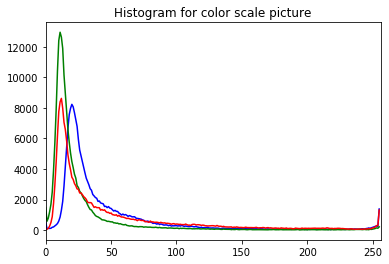

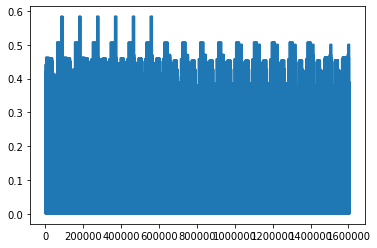

Feature agglomeration for color histogram data - 


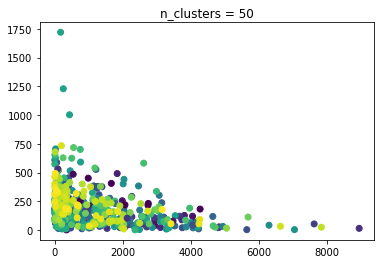

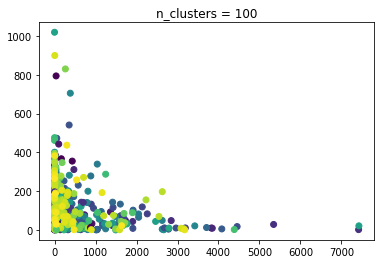

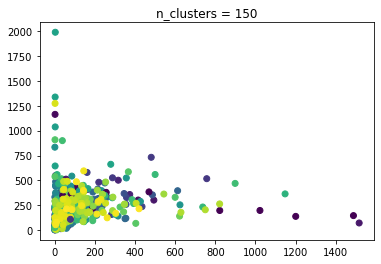

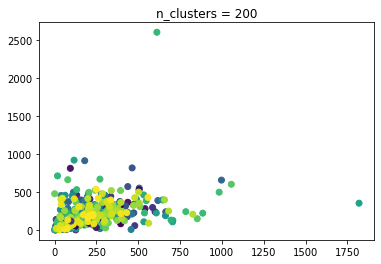

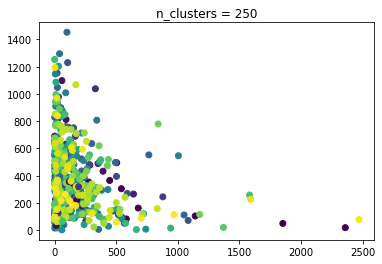

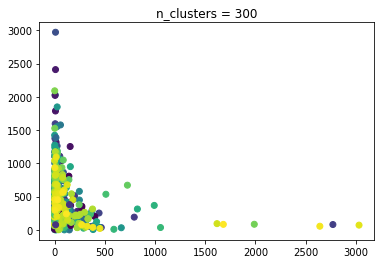

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 500 samples in 2.113s...
[t-SNE] Computed neighbors for 500 samples in 189.305s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 34.049985
[t-SNE] KL divergence after 250 iterations with early exaggeration: 109.951309
[t-SNE] KL divergence after 1000 iterations: 1.300109
t-SNE for RGB done! Time elapsed: 195.96541595458984 seconds


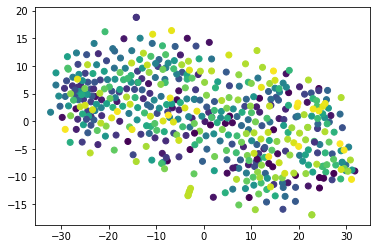

*************************************************************
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.021s...
[t-SNE] Computed neighbors for 500 samples in 0.348s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 2405.718604
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.280014
[t-SNE] KL divergence after 800 iterations: 0.752373
t-SNE for Color Hist done! Time elapsed: 4.18930983543396 seconds


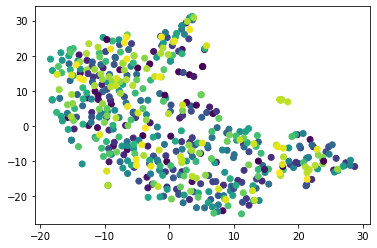

*************************************************************
Total features After t-SNE and Feature Agglomeration -  154
Prefitting XGBoost ..... 
Selected  13 features with threshold =  0.008


In [4]:
n = 500
s = 0
selection, select_X_train = read_and_reduce(images_path,s,n)

In [5]:
selection_model = XGBClassifier(learning_rate =0.02,
 n_estimators=4000,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=1,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
selection_model.fit(select_X_train, photo_id_to_business[:n])
# eval model
#select_X_test = selection.transform(train_data_raw)
y_pred = selection_model.predict(select_X_train)
#predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(photo_id_to_business[s:n], y_pred)
print("n=%d, Accuracy: %.2f%%" % (select_X_train.shape[1], accuracy*100.0))

n=13, Accuracy: 13.00%


In [6]:
def read_and_reduce_test(images_path,s,n):
    train_images=[]
    hist_data = []
    hog_data = []
    channels = 3
    for image_path in images_path[s:n]:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
        color = ('b','g','r')
        temp = []
        for channel,col in enumerate(color):
            temp.append(cv2.calcHist([image],[channel],None,[256],[0,256]))
        temp1 = np.append(temp[0],temp[1],axis=0)
        temp = np.append(temp1,temp[2],axis=0)
        hist_data.append(temp)
        train_images.append(image)
        hog = cv2.HOGDescriptor()
        hog_data.append(hog.compute(image))
    train_images = np.array(train_images, dtype=np.uint8)
    train_images = train_images.astype('float32')
    train_images = np.multiply(train_images, 1.0/255.0) 
    img = cv2.imread("yelp_photos/photos/"+df_photos['photo_id'][np.random.randint(n-s,)]+".jpg", -1)
    color = ('b','g','r')

    for channel,col in enumerate(color):
        histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    len_hist = len(hist_data[0])
    hist_data = np.array(hist_data)
    len_hog = len(hog_data[0])
    hog_data = np.array(hog_data)
    train_images1 = train_images.reshape(len(train_images),-1)
    hist_data = hist_data.reshape(len(train_images),len_hist)
    hog_data = hog_data.reshape(len(train_images), len_hog)
    agglo=FeatureAgglomeration(n_clusters=100).fit_transform(hist_data)
    agglo_hist=FeatureAgglomeration(n_clusters=150).fit_transform(hist_data)
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000)
    tsne_results_RGB = tsne.fit_transform(train_images1,photo_id_to_business[s:n])

    print ('t-SNE for RGB done! Time elapsed: {} seconds'.format(time.time()-time_start))
    print('*************************************************************')
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=800)
    tsne_results_hist = tsne.fit_transform(hist_data,photo_id_to_business[s:n])

    print ('t-SNE for Color Hist done! Time elapsed: {} seconds'.format(time.time()-time_start))
    print('*************************************************************')
    train_data = np.append(tsne_results_hist,tsne_results_RGB,axis=1)
    train_data = np.append(train_data, agglo_hist, axis=1)
    select_X_test = selection.transform(train_data)
    return select_X_test

In [7]:
s = 0
n = 500
select_X_test = read_and_reduce_test(images_path,s,n)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 500 samples in 2.065s...
[t-SNE] Computed neighbors for 500 samples in 68.936s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 34.049985
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.791412
[t-SNE] KL divergence after 1000 iterations: 1.266237
t-SNE for RGB done! Time elapsed: 73.17040300369263 seconds
*************************************************************
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.004s...
[t-SNE] Computed neighbors for 500 samples in 0.256s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 2405.718604
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.450470
[t-SNE] KL divergence after 800 iterations: 0.770290
t-SNE for Color Hist done! Time elapsed: 1.9217278957366943 seconds
*************************************************************


In [8]:
y_pred_test = selection_model.predict(select_X_test)
accuracy = accuracy_score(photo_id_to_business[s:n], y_pred_test)
print("n=%d, Accuracy: %.2f%%" % (select_X_test.shape[1], accuracy*100.0))

n=13, Accuracy: 13.00%
